# Project: We Rate Dogs Data Wrangling and Analyze

In [13]:
#Import packages
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
import re
import creds
import matplotlib.pyplot as plt
import warnings
from IPython.display import Image
from functools import reduce
import seaborn as sns
import datetime
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [14]:
#Upload and observe the csv file
twitter_df_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [15]:
#Make directory of folder
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

### The tweet image predictions

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [16]:
#Download the tweets image predictions TSV using the requests library and transpose into the image_predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

#Create the file
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
#Import the tweet image predictions TSV file into a DataFrame
image_prediction = pd.read_csv('image_predictions.tsv', sep='\t')

In [17]:
#Twitter API - get tweets with specific id
consumer_key = '0j0qBYN8QPVX1voLwLm81oX9y'
consumer_secret = 'ktoBKGrhcMghNGFpBj6hncXt5UHShIUqlT69AVi1mFrjNCcjbN'
access_token = '67008093-z5tfGeQPzfWPBR7hWKc2CLzs5vzq2TGWPMnbYl3hN'
access_secret = 'xjINlee1tFyCNr3XreUvFpUAew8j7AHcGulkIbY2kp8nX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)

### REF :https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id

### Additional data from the Twitter API

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [18]:
#For loop which will add each available tweet to a new line of tweet-json.txt
with open('tweet_json.txt', 'a', encoding='utf8') as f:
    for tweet_id in twitter_df_archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            continue

Rate limit reached. Sleeping for: 682
Rate limit reached. Sleeping for: 674


In [23]:
twitter_list = []
for line in open('tweet_json.txt'):
    twitter_data = json.loads(line)
    if line.strip() == "":
        continue
    twitter_list.append({
        'tweet_id' : twitter_data['id_str'],
        'retweet_count': twitter_data['retweet_count'],
        'favorite_count' :  twitter_data['favorite_count'],
        'followers_count': twitter_data['user']['followers_count']        
    })

In [24]:
#Convert the list of dictionaries to a pandas DataFrame
twitter_data = pd.DataFrame(twitter_list, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'followers_count'])

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [25]:
twitter_data.head(10)

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,6982,33746,9327518
1,892177421306343426,5284,29260,9327988
2,891815181378084864,3469,22001,9327519
3,891689557279858688,7205,36856,9327519
4,891327558926688256,7730,35235,9327519
5,891087950875897856,2593,17770,9327517
6,890971913173991426,1651,10347,9327519
7,890729181411237888,15707,56731,9327519
8,890609185150312448,3609,24463,9327519
9,890240255349198849,6085,27887,9327519


In [26]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2327 non-null   object
 1   retweet_count    2327 non-null   int64 
 2   favorite_count   2327 non-null   int64 
 3   followers_count  2327 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 72.8+ KB


In [27]:
  image_prediction.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [28]:
image_prediction.duplicated().sum()

0

In [29]:
twitter_df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [30]:
twitter_df_archive[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [31]:
 twitter_df_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [32]:
twitter_df_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [33]:
twitter_df_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [34]:
 twitter_df_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [35]:
 twitter_df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [36]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [37]:
 image_prediction.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [38]:
 twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2327 non-null   object
 1   retweet_count    2327 non-null   int64 
 2   favorite_count   2327 non-null   int64 
 3   followers_count  2327 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 72.8+ KB


### Quality issues

#### twitter_df_archive table

1. Keep the original ratings that have images retweets

2. drop unwanted columns

3. Incorrect datatypes in the above columns (tweet_id, rating_denominator,rating_numerator, in_reply_to_status_id, in_reply_to_user_id, timestamp, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, doggo, floofer, pupper, and puppo)

4. Correct the numerators with decimal values

5. Wrong dog names

6. Missing URLs in expanded_urls

7. Source column is in HTML-formatted string, not a normal string

8. Error in dog names (e.g a,an,actually) are not a dog's name

9. Some values in rating_numerator and rating_denominator seem to be in error or dubious outliers

10. text column includes a text and a short link

#### Image prediction table

1. Wrong datatypes

2. Unavailable images


#### Twitter API table

1. Wrong datatypes

2. Missing tweets

### Tidiness issues

#### twitter_df_archive table

1. doggo, floofer, pupper and puppo columns in twitter_archive table should be merged into one column named 'dog_stage'

#### Image prediction table

2. Image predictions table should be added to twitter archive table

#### Twitter API table

3. twitter api table columns(retweet_count, favorite_count, followers_count) should be added to twitter archive table.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [39]:
# Make copies of original pieces of data

archive_clean = twitter_df_archive.copy()
image_clean = image_prediction.copy()
twitterapi_clean = twitter_data.copy()

In [40]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Issue #1: 

#### Define: Keep the original ratings that have images with no retweets

#### Code

In [41]:
#Remove retweets by filtering the NaN of the retweeted_status_user_id
archive_clean = archive_clean[pd.isnull(archive_clean['retweeted_status_user_id'])]

#### Test

In [42]:
#justify the changes
print(sum(archive_clean.retweeted_status_user_id.value_counts()))

0


### Issue #2:

#### Define: drop unwanted columns

#### Code

In [43]:
#Drop unwanted columns
archive_clean = archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                                            'retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls'], 1)

C:\Users\reart\AppData\Local\Temp/ipykernel_8660/3393570324.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  archive_clean = archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',


#### Test

In [44]:
#Confirm the changes
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   rating_numerator    2175 non-null   int64 
 5   rating_denominator  2175 non-null   int64 
 6   name                2175 non-null   object
 7   doggo               2175 non-null   object
 8   floofer             2175 non-null   object
 9   pupper              2175 non-null   object
 10  puppo               2175 non-null   object
dtypes: int64(3), object(8)
memory usage: 203.9+ KB


### Issue #3:

#### Define: Missing datatypes

#### Code

In [45]:
#Convert the tweet_id to str from twitter_archive, image_prediction, twitter_data tables.
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
image_clean.tweet_id = image_clean.tweet_id.astype(str)
twitterapi_clean.tweet_id = archive_clean.tweet_id.astype(str)

#Convert the timestamp to datetime
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

#Convert source to category datatype
archive_clean.source = archive_clean.source.astype('category')

#### Test

In [46]:
#Confirm the changes
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   int64              
 5   rating_denominator  2175 non-null   int64              
 6   name                2175 non-null   object             
 7   doggo               2175 non-null   object             
 8   floofer             2175 non-null   object             
 9   pupper              2175 non-null   object             
 10  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC](1), int64(2), object(7)
memory usage: 253.8+ KB


### Issue #4:

#### Define: Correct the numerators with decimal values

#### Code

In [47]:
#Observe the codes to ensure the decimals were included in the process of extraction.

with pd.option_context('max_colwidth', 200):
    display(twitter_df_archive[twitter_df_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Users\reart\AppData\Local\Temp/ipykernel_8660/499759670.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  display(twitter_df_archive[twitter_df_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")]


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [48]:
#Convert all to float datatype
archive_clean[['rating_numerator', 'rating_denominator']] = archive_clean[['rating_numerator','rating_denominator']].astype(float)

#Update to the necessary location
archive_clean.loc[(archive_clean.tweet_id == 883482846933004288), 'rating_numerator'] = 13.5
archive_clean.loc[(archive_clean.tweet_id == 786709082849828864), 'rating_numerator'] = 9.75
archive_clean.loc[(archive_clean.tweet_id == 778027034220126208), 'rating_numerator'] = 11.27
archive_clean.loc[(archive_clean.tweet_id == 681340665377193984), 'rating_numerator'] = 9.5
archive_clean.loc[(archive_clean.tweet_id == 680494726643068929), 'rating_numerator'] = 11.26

#### Test

In [49]:
#Confirm the changes
with pd.option_context('max_colwidth', 200):
    display(archive_clean[archive_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

C:\Users\reart\AppData\Local\Temp/ipykernel_8660/2157194461.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  display(archive_clean[archive_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27.0,10.0
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5.0,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0,10.0


### Issue 5:

#### Define: Wrong dog names

In [50]:
archive_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'such', 'Canela',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody',
       'Lassie', 'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble',
       'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper',
       'Harold', 'Shikha', 'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave',
    

#### Code

In [51]:
archive_clean['name'][archive_clean['name'].str.match('[a-z]+')] = 'None'

C:\Users\reart\AppData\Local\Temp/ipykernel_8660/1525449282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  archive_clean['name'][archive_clean['name'].str.match('[a-z]+')] = 'None'


#### Test

In [52]:
#Confirm the changes
archive_clean.name.value_counts()

None          784
Lucy           11
Charlie        11
Cooper         10
Oliver         10
             ... 
Shelby          1
Sephie          1
Bonaparte       1
Wishes          1
Christoper      1
Name: name, Length: 931, dtype: int64

### Issue 6:

#### Define: Rows with more than 1 dog stage

#### Code

In [53]:
#Combine all dog stages
archive_clean['add_all'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

In [54]:
#Observe
archive_clean.add_all.value_counts()

NoneNoneNoneNone        1831
NoneNonepupperNone       224
doggoNoneNoneNone         75
NoneNoneNonepuppo         24
doggoNonepupperNone       10
NoneflooferNoneNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: add_all, dtype: int64

In [55]:
#Create a function to examine dog stages
def check_stages(archive):
    if archive['add_all'].count('None') == 2:
        return 'Multiple' #this means it has more than one dog stage
    else:
        if archive['add_all'].count('doggo') == 1:
            return 'Doggo'
        elif archive['add_all'].count('floofer') == 1:
            return 'Floofer'
        elif archive['add_all'].count('pupper') == 1:
            return 'Pupper'
        elif archive['add_all'].count('puppo') == 1:
            return 'Puppo'
        else:
            return 'None'

archive_clean['dog_stage'] = archive_clean.apply(check_stages, axis = 1)

#### Test

In [56]:
 archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   float64            
 5   rating_denominator  2175 non-null   float64            
 6   name                2175 non-null   object             
 7   doggo               2175 non-null   object             
 8   floofer             2175 non-null   object             
 9   pupper              2175 non-null   object             
 10  puppo               2175 non-null   object             
 11  add_all             2175 non-null   object             
 12  dog_stage           2175 non-null 

### Issue 7:

#### Define: Remove unused rows

#### Code

In [57]:
#Drop unused columns
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo', 'add_all'], axis = 1, inplace = True)

In [58]:
#Convert all to datatype - category 
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

#### Test

In [59]:
#Obseerve the changes
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   float64            
 5   rating_denominator  2175 non-null   float64            
 6   name                2175 non-null   object             
 7   dog_stage           2175 non-null   category           
dtypes: category(2), datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 188.1+ KB


In [60]:
#Observe the changes
archive_clean.dog_stage.value_counts()

None        1831
Pupper       224
Doggo         75
Puppo         24
Multiple      12
Floofer        9
Name: dog_stage, dtype: int64

In [61]:
#Observe the new changes
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   float64            
 5   rating_denominator  2175 non-null   float64            
 6   name                2175 non-null   object             
 7   dog_stage           2175 non-null   category           
dtypes: category(2), datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 188.1+ KB


### Issue 8:

#### Define: Convert columns from HTML formatted strings to regular columns

#### Code

In [62]:
#Extract the values
archive_clean.source = archive_clean.source.str.extract('>([\w\W\s]*)<', expand = True)

#### Test

In [63]:
#Observe the changes
archive_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

#### Ref:

1. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html

2. https://stackoverflow.com/questions/13682044/remove-unwanted-parts-from-strings-in-a-column?noredirect=1

### Issue 9:

#### Define: Remove all hyperlinks inbetween tweets

#### Code

In [64]:
#Write the function to archive_clean table
def htmlink(x):
        http_pos = x.find("http")
        # If no link, retain row
        if http_pos == -1:
            x = x
        else:
            # Remove space before link to end
            x = x[:http_pos - 1]
        return x
    
archive_clean.text = archive_clean.text.apply(htmlink)

#### Test

In [65]:
#Observe the changes to the tweets with no hyperlink
for row in archive_clean.text[:10]:
    print(row)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us
This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek
Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek
Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below

When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10
This is Zoey. She doesn't want to be one of the scary shark

#### Ref:
1. https://stackoverflow.com/questions/13682044/remove-unwanted-parts-from-strings-in-a-column?noredirect=1

### Tidiness

### Issue 1:

#### Define: Converge the  twitter api table and image prediction table to the twitter_df_archive table

#### Code

In [66]:
#Converge both tables
archive_clean = pd.merge(left = archive_clean, right = twitterapi_clean, how = 'left', on = 'tweet_id')
archive_clean = pd.merge(left = archive_clean, right = image_clean, how = 'left', on = 'tweet_id')

#### Test

In [67]:
#Observe the changes
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   float64            
 5   rating_denominator  2175 non-null   float64            
 6   name                2175 non-null   object             
 7   dog_stage           2175 non-null   category           
 8   retweet_count       2146 non-null   float64            
 9   favorite_count      2146 non-null   float64            
 10  followers_count     2146 non-null   float64            
 11  jpg_url             1994 non-null   object             
 12  img_num             1994 non-null 

### Issue 2:

#### Define: Remove all tweets with no images

#### Code

In [68]:
#Remove rows with no image
archive_clean.dropna(axis = 0, inplace = True)

#### Test

In [69]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 2145
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1965 non-null   object             
 1   timestamp           1965 non-null   datetime64[ns, UTC]
 2   source              1965 non-null   object             
 3   text                1965 non-null   object             
 4   rating_numerator    1965 non-null   float64            
 5   rating_denominator  1965 non-null   float64            
 6   name                1965 non-null   object             
 7   dog_stage           1965 non-null   category           
 8   retweet_count       1965 non-null   float64            
 9   favorite_count      1965 non-null   float64            
 10  followers_count     1965 non-null   float64            
 11  jpg_url             1965 non-null   object             
 12  img_num             1965 non-null 

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [70]:
#Load the dataset
archive_clean.to_csv('twitter_archive_master.csv', index = False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [71]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965 entries, 0 to 1964
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1965 non-null   int64  
 1   timestamp           1965 non-null   object 
 2   source              1965 non-null   object 
 3   text                1965 non-null   object 
 4   rating_numerator    1965 non-null   float64
 5   rating_denominator  1965 non-null   float64
 6   name                1965 non-null   object 
 7   dog_stage           1965 non-null   object 
 8   retweet_count       1965 non-null   float64
 9   favorite_count      1965 non-null   float64
 10  followers_count     1965 non-null   float64
 11  jpg_url             1965 non-null   object 
 12  img_num             1965 non-null   float64
 13  p1                  1965 non-null   object 
 14  p1_conf             1965 non-null   float64
 15  p1_dog              1965 non-null   bool   
 16  p2    

In [72]:
#Reconvert datatypes again
twitter_archive_master.tweet_id = twitter_archive_master.tweet_id.astype(str)
twitter_archive_master.dog_stage = twitter_archive_master.dog_stage.astype("category")
twitter_archive_master[['rating_numerator', 'rating_denominator']] = twitter_archive_master[['rating_numerator', 'rating_denominator']].astype(float)
twitter_archive_master[['retweet_count', 'favorite_count', 'followers_count']] = twitter_archive_master[['retweet_count', 'favorite_count', 'followers_count']].astype(int)
twitter_archive_master.source = twitter_archive_master.source.astype("category")
twitter_archive_master.timestamp = pd.to_datetime(twitter_archive_master.timestamp)

In [73]:
#Observe after conversion
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965 entries, 0 to 1964
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1965 non-null   object             
 1   timestamp           1965 non-null   datetime64[ns, UTC]
 2   source              1965 non-null   category           
 3   text                1965 non-null   object             
 4   rating_numerator    1965 non-null   float64            
 5   rating_denominator  1965 non-null   float64            
 6   name                1965 non-null   object             
 7   dog_stage           1965 non-null   category           
 8   retweet_count       1965 non-null   int32              
 9   favorite_count      1965 non-null   int32              
 10  followers_count     1965 non-null   int32              
 11  jpg_url             1965 non-null   object             
 12  img_num             1965 non-null 

### Insights:
1. What's the growth of total number of tweets over time ?

2. What's the different dog categories/breeds? 

3. What's the most popular dog names?

### Visualization

#### 1. Visualize the total number of tweets over time and makes inferences of either an increase, decreas or neutral growth.

In [74]:
archive_clean.timestamp = pd.to_datetime(archive_clean['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

monthly_tweets = archive_clean.groupby(pd.Grouper(key = 'timestamp', freq = "M")).count().reset_index()
monthly_tweets = monthly_tweets[['timestamp', 'tweet_id']]
monthly_tweets.head()
monthly_tweets.sum()

C:\Users\reart\AppData\Local\Temp/ipykernel_8660/2101303542.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  monthly_tweets.sum()


tweet_id    1965
dtype: int64

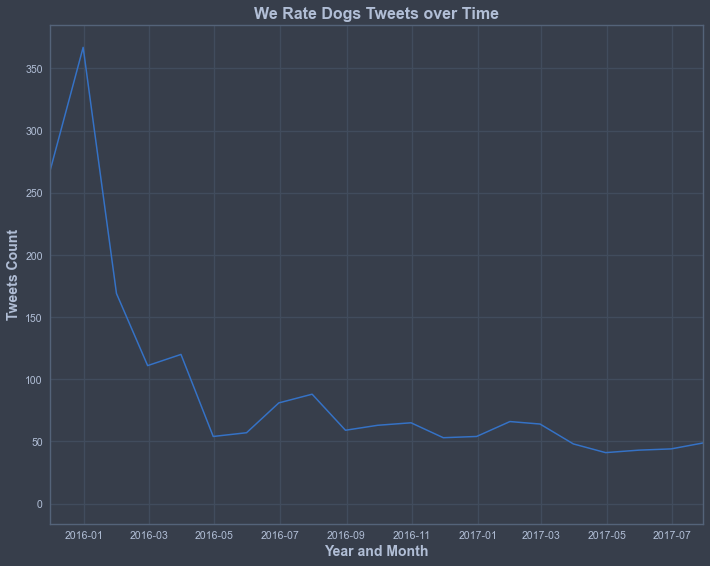

In [75]:
#A graph of time vs. tweets

plt.figure(figsize=(10, 8));
plt.xlim([datetime.date(2015, 11, 30), datetime.date(2017, 7, 30)]);

plt.xlabel('Year and Month', 
           size = 14, 
           fontweight = 'bold')
plt.ylabel('Tweets Count', 
           size = 14, 
           fontweight = 'bold')

plt.plot(monthly_tweets.timestamp, monthly_tweets.tweet_id);
plt.title('We Rate Dogs Tweets over Time', 
          size = 16, 
           fontweight = 'bold');

Considering the visualization created, the tweets drastically increased from 12-2015 to 01-2016 before quickly dropping to 03-2016 with a slight spike on 04-2016. From 04-2016, the tweets gradually decreased over time with slight fluctuations recorded at 08-2016. 11-2016 and 02-2016 over the course of time

#### 2. Visualize the retweet counts, and favorite counts comparison over time

In [76]:
archive_clean['dog_stage'].value_counts()

None        1659
Pupper       203
Doggo         63
Puppo         22
Multiple      11
Floofer        7
Name: dog_stage, dtype: int64

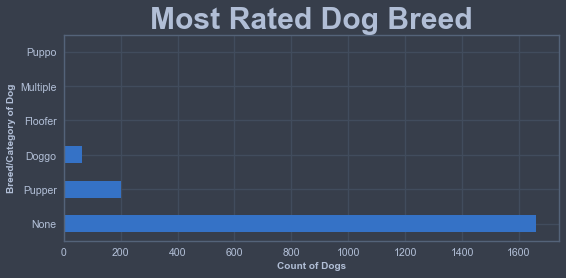

In [77]:
#A histogram of different dog stages
dog_category = archive_clean.groupby('dog_stage').filter(lambda x: len(x) >= 25)

dog_category['dog_stage'].value_counts().plot(kind = 'barh')
plt.title('Most Rated Dog Breed', 
           size = 30, 
           fontweight = 'bold')
plt.xlabel('Count of Dogs', 
           size = 10, 
           fontweight = 'bold')
plt.ylabel('Breed/Category of Dog', 
           size = 10, 
           fontweight = 'bold');

Concerning this visualization, the varying breeds of dogs are Pupper, Doggo, Floofer, Multiple, and Puppo. Pupper has the most counts of dogs in that category with 203 followed by Doggo averaging 63 counts. Puppo, Multiple, and Floofer have 22, 11, and 7 counts respectively

#### 3.Visualize the most popular dog names

In [78]:
popular_name = twitter_archive_master.name.value_counts()[1:10]

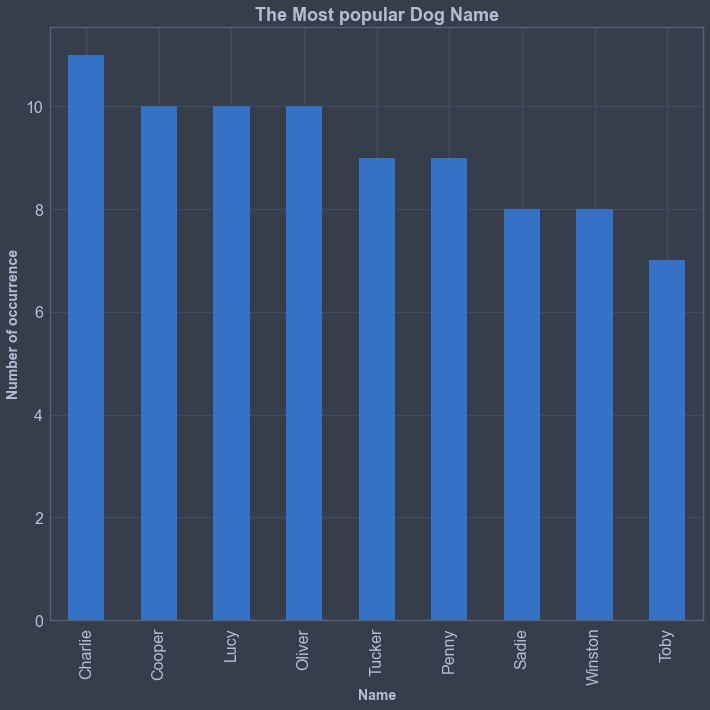

In [79]:
#A graph of dog names againt counts
bar_graph = popular_name.plot.bar(fontsize = 16)

#figure size(width, height)
bar_graph.figure.set_size_inches(10, 10);

#Add labels
plt.title('The Most popular Dog Name', 
           size = 18,
           fontweight = 'bold')
plt.xlabel('Name', 
            size = 14, 
            fontweight = 'bold')
plt.ylabel('Number of occurrence',
            size = 14, 
            fontweight = 'bold');

From the analysis, the most popular dog names are Charlie, Lucy, Oliver, Cooper, Tucker, Penny, Sadie, Winston, and Toby. Charlie occurred 11 times, followed by Lucy, Oliver and Cooper all mentioned 10 times each. Tucker and Penny summed up to 9 times whereas and Sadie and Winston produced 8 counts each with Toby corresponding to 7 counts.